In [1]:
# colab only
# !pip install transformers

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import transformers
# from google.colab import files

In [3]:
# colab only

# file_dict = files.upload()

# from zipfile import ZipFile
# file_name = 'BrainTumorData.zip'

# if not 'BrainTumorData' in os.listdir('.'):
#   with ZipFile(file_name, 'r') as zip:
#     zip.extractall()
#     print('Done')

In [4]:
####################
# NOTE: this notebook assumes the brain tumor data is in a directory at the root
# of this repository called 'BrainTumorData'.
#
# To make this work:
# 1 - go to https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
# 2 - download the .zip file to this directory
# 3 - unzip the archive
# 4 - rename the expanded directory to BrainTumorData


data_directory = os.path.join(os.getcwd(), 'BrainTumorData')
train_dir = os.path.join(data_directory, 'Training')
test_dir = os.path.join(data_directory, 'Testing')

train_imgs = []
train_labels = []

test_imgs = []
test_labels = []


# get labels from the file structure
for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_imgs.append (img) 
        train_labels.append(label)
        
for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_imgs.append (img) 
        train_labels.append(label)


In [5]:
# dataloaders only support tensors, np arrays, lists, dicts, and numbers
# define this function to cast PIL images to tensors
transform_fn = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

# create a validation set from the test set
x_train, x_val, y_train, y_val = train_test_split(np.array(train_imgs), np.array(train_labels), test_size=0.1)

# create dataloaders
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_dir, transform=transform_fn),
    batch_size=64,
    shuffle=True,
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_dir, transform=transform_fn),
    batch_size=32,
    shuffle=False,
)

In [6]:
# get class names
class_names = [label for label in os.listdir(train_dir)]

# support GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# define the model and send it to the device
model = models.resnet18().to(device)

In [8]:
# some deep learning overhead to help the model learn better
# can tweak these if you want but don't need to
warmup_steps = 0 # delays using learning rate
num_epochs = 20 
learning_rate = 5e-3 # initial LR used after warmup
weight_decay = 0.0 # throttles optimizer -- 0 for now

num_update_steps_per_epoch = len(train_loader)
max_train_steps = num_epochs * num_update_steps_per_epoch

optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay,
)

lr_scheduler = transformers.get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=max_train_steps,
)

In [9]:
def get_accuracy(predicted, labels):
    batch_len, correct = 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate_model(model, test_loader):
    # set the model to evaluation mode
    losses = 0
    num_samples_total = 0
    correct_total = 0
    model.eval()
    for inputs, labels in tqdm(test_loader, desc='evaluating'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += b_len
        correct_total += corr
        
    accuracy = correct_total / num_samples_total
    losses = losses / len(test_loader)
    return accuracy, losses
        

In [10]:
# training loop
criterion = nn.CrossEntropyLoss()
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in tqdm(range(num_epochs), desc='training epochs'):
    # set the model to train mode
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    num_samples_total = 0
    counter = 0
    
    for images, labels in tqdm(train_loader, desc='train batches'):
        counter += 1
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total += b_len
        train_running_correct += corr
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    train_acc = train_running_correct / num_samples_total
    train_loss = train_running_loss / len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate at the end of each epoch
    # Mike TODO
#         train_running_loss += loss.item()
        
#         preds = torch.max(outputs,1)
#         train_running_correct += preds.sum().item()
        
#         optimizer.step()
    
    
#     epoch_loss = train_running_loss / counter
#     epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    
    epoch_acc, epoch_loss = evaluate_model(model, test_loader)
    val_accs.append(epoch_acc)
    val_losses.append(epoch_loss)
    print("Epoch", epoch + 1)
    print("Epoch loss: ", epoch_loss)
    print("Epoch accuracy: ", epoch_acc)

# save the model checkpoint after training
# in case we want to use it again for class demo
output_dir = 'output'
try:
    os.mkdir(output_dir)
except:
    # we don't care if it already exists... move on
    pass

torch.save(model.state_dict(), "resNetModule.pt")

train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:41<00:00,  7.60s/it]

training epochs:   5%|██████▎                                                                                                                      | 1/20 [05:56<1:52:59, 356.84s/it]

Epoch 1
Epoch loss:  2.4110988561923685
Epoch accuracy:  0.3883248730964467



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:16<00:00,  7.03s/it]

training epochs:  10%|████████████▌                                                                                                                | 2/20 [11:25<1:42:01, 340.08s/it]

Epoch 2
Epoch loss:  2.6668403240350576
Epoch accuracy:  0.32741116751269034



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:40<00:00,  7.58s/it]

training epochs:  15%|██████████████████▊                                                                                                          | 3/20 [17:19<1:38:13, 346.70s/it]

Epoch 3
Epoch loss:  2.126831971682035
Epoch accuracy:  0.39593908629441626



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:32<00:00,  7.38s/it]

training epochs:  20%|█████████████████████████                                                                                                    | 4/20 [23:05<1:32:18, 346.17s/it]

Epoch 4
Epoch loss:  2.465392463482343
Epoch accuracy:  0.4467005076142132



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:26<00:00,  7.25s/it]

training epochs:  25%|███████████████████████████████▎                                                                                             | 5/20 [28:43<1:25:52, 343.52s/it]

Epoch 5
Epoch loss:  2.5098720353383284
Epoch accuracy:  0.5177664974619289



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:26<00:00,  7.25s/it]

training epochs:  30%|█████████████████████████████████████▌                                                                                       | 6/20 [34:22<1:19:44, 341.76s/it]

Epoch 6
Epoch loss:  2.2883558628650813
Epoch accuracy:  0.5101522842639594



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:28<00:00,  7.30s/it]

training epochs:  35%|███████████████████████████████████████████▊                                                                                 | 7/20 [40:04<1:14:04, 341.89s/it]

Epoch 7
Epoch loss:  2.248569101668321
Epoch accuracy:  0.4873096446700508



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:34<00:00,  7.44s/it]

training epochs:  40%|██████████████████████████████████████████████████                                                                           | 8/20 [45:52<1:08:46, 343.84s/it]

Epoch 8
Epoch loss:  2.200423232637919
Epoch accuracy:  0.6116751269035533



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:34<00:00,  7.42s/it]

training epochs:  45%|████████████████████████████████████████████████████████▎                                                                    | 9/20 [51:39<1:03:14, 344.95s/it]

Epoch 9
Epoch loss:  1.920926587226299
Epoch accuracy:  0.649746192893401



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:36<00:00,  7.47s/it]

training epochs:  50%|███████████████████████████████████████████████████████████████                                                               | 10/20 [57:29<57:42, 346.27s/it]

Epoch 10
Epoch loss:  2.1753010543493123
Epoch accuracy:  0.682741116751269



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:34<00:00,  7.43s/it]

training epochs:  55%|████████████████████████████████████████████████████████████████████▏                                                       | 11/20 [1:03:17<52:02, 346.98s/it]

Epoch 11
Epoch loss:  2.009234546468808
Epoch accuracy:  0.6979695431472082



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:29<00:00,  7.33s/it]

training epochs:  60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 12/20 [1:09:01<46:07, 345.92s/it]

Epoch 12
Epoch loss:  2.3437067739164026
Epoch accuracy:  0.6472081218274112



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:28<00:00,  7.30s/it]

training epochs:  65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 13/20 [1:14:43<40:14, 344.90s/it]

Epoch 13
Epoch loss:  1.8887581140376055
Epoch accuracy:  0.6928934010152284



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:37<00:00,  7.50s/it]

training epochs:  70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 14/20 [1:20:34<34:40, 346.69s/it]

Epoch 14
Epoch loss:  2.098914768922931
Epoch accuracy:  0.7182741116751269



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:38<00:00,  7.53s/it]

training epochs:  75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 15/20 [1:26:26<29:01, 348.35s/it]

Epoch 15
Epoch loss:  2.1524002827309934
Epoch accuracy:  0.7258883248730964



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:24<00:00,  7.21s/it]

training epochs:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 16/20 [1:32:03<22:59, 344.93s/it]

Epoch 16
Epoch loss:  2.3736368235326015
Epoch accuracy:  0.7411167512690355



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:49<00:00,  7.77s/it]

training epochs:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 17/20 [1:38:08<17:32, 350.79s/it]

Epoch 17
Epoch loss:  2.2542713470577906
Epoch accuracy:  0.751269035532995



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:47<00:00,  7.73s/it]

training epochs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 18/20 [1:44:11<11:49, 354.51s/it]

Epoch 18
Epoch loss:  2.2242203367372544
Epoch accuracy:  0.7461928934010152



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [06:08<00:00,  8.19s/it]

training epochs:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 19/20 [1:50:34<06:03, 363.17s/it]

Epoch 19
Epoch loss:  2.2143518953190116
Epoch accuracy:  0.751269035532995



train batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [06:00<00:00,  8.01s/it]

training epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:56:49<00:00, 350.48s/it]


Epoch 20
Epoch loss:  2.134703516431798
Epoch accuracy:  0.751269035532995


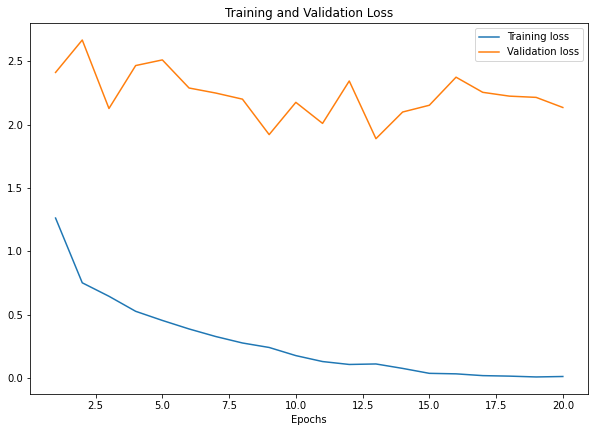

<Figure size 432x288 with 0 Axes>

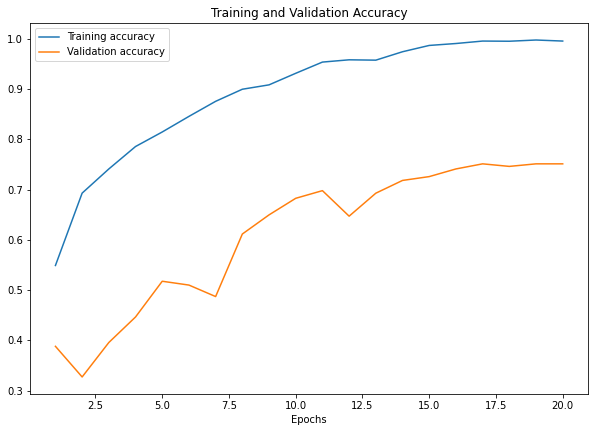

<Figure size 432x288 with 0 Axes>

In [11]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, train_losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, train_accs, label='Training accuracy')
plt.plot(epoch, val_accs, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [12]:
# summary results
for i, acc in enumerate(val_accs):
    print(f'Epoch {i + 1} - validation accuracy: {acc}')

Epoch 1 - validation accuracy: 0.3883248730964467
Epoch 2 - validation accuracy: 0.32741116751269034
Epoch 3 - validation accuracy: 0.39593908629441626
Epoch 4 - validation accuracy: 0.4467005076142132
Epoch 5 - validation accuracy: 0.5177664974619289
Epoch 6 - validation accuracy: 0.5101522842639594
Epoch 7 - validation accuracy: 0.4873096446700508
Epoch 8 - validation accuracy: 0.6116751269035533
Epoch 9 - validation accuracy: 0.649746192893401
Epoch 10 - validation accuracy: 0.682741116751269
Epoch 11 - validation accuracy: 0.6979695431472082
Epoch 12 - validation accuracy: 0.6472081218274112
Epoch 13 - validation accuracy: 0.6928934010152284
Epoch 14 - validation accuracy: 0.7182741116751269
Epoch 15 - validation accuracy: 0.7258883248730964
Epoch 16 - validation accuracy: 0.7411167512690355
Epoch 17 - validation accuracy: 0.751269035532995
Epoch 18 - validation accuracy: 0.7461928934010152
Epoch 19 - validation accuracy: 0.751269035532995
Epoch 20 - validation accuracy: 0.75126903